# NICE Challenge

### Importing the data

#### Note: I had to delete an extra character in the ID column name on the csv, since this was giving me encoding errors.

In [1]:
import pandas as pd
data = pd.read_csv('ChicagoCrimeData-master\Chicago_Crime_2013_2015.csv', parse_dates = ['Date'])
data

,ID,Case.Number,Date,Block,IUCR,Primary.Type,Description,Location.Description,Arrest,Domestic,...,Ward,Community.Area,FBI.Code,X.Coordinate,Y.Coordinate,Year,Updated.On,Latitude,Longitude,Location
0,10124853,HY313560,2015-06-23 23:50:00,024XX S KEDVALE AVE,820,THEFT,$500 AND UNDER,STREET,False,False,...,22.0,30.0,6,1149248.0,1887712.0,2015,6/30/2015 12:40,41.847805,-87.727747,"(41.84780493, -87.727747291)"
1,10124960,HY313663,2015-06-23 23:45:00,051XX S WENTWORTH AVE,454,BATTERY,AGG PO HANDS NO/MIN INJURY,POLICE FACILITY/VEH PARKING LOT,True,False,...,3.0,37.0,08B,1175865.0,1871146.0,2015,6/30/2015 12:40,41.801790,-87.630560,"(41.801789811, -87.630559815)"
2,10124917,HY313603,2015-06-23 23:42:00,049XX W RACE AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,APARTMENT,True,False,...,37.0,25.0,15,1143419.0,1903252.0,2015,6/30/2015 12:40,41.890559,-87.748752,"(41.890559483, -87.748751767)"
3,10124869,HY313604,2015-06-23 23:42:00,049XX W RACE AVE,2027,NARCOTICS,POSS: CRACK,APARTMENT,True,False,...,37.0,25.0,18,1143419.0,1903252.0,2015,6/30/2015 12:40,41.890559,-87.748752,"(41.890559483, -87.748751767)"
4,10124873,HY313566,2015-06-23 23:40:00,070XX S STATE ST,496,BATTERY,AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST,SIDEWALK,False,True,...,6.0,69.0,04B,1177469.0,1858544.0,2015,6/30/2015 12:40,41.767173,-87.625058,"(41.767172506, -87.625058064)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697012,9103032,HW247232,2013-01-01 00:00:00,007XX W SCHUBERT AVE,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,APARTMENT,False,False,...,43.0,7.0,11,1171019.0,1918449.0,2013,4/26/2013 11:02,41.931700,-87.646945,"(41.931700156, -87.646944847)"
697013,9372459,HW515117,2013-01-01 00:00:00,063XX S CALIFORNIA AVE,1120,DECEPTIVE PRACTICE,FORGERY,CURRENCY EXCHANGE,False,False,...,15.0,66.0,10,1158757.0,1862683.0,2013,11/7/2013 15:34,41.778933,-87.693533,"(41.778932885, -87.693532699)"
697014,9101785,HW245940,2013-01-01 00:00:00,065XX S WOLCOTT AVE,842,THEFT,AGG: FINANCIAL ID THEFT,RESIDENCE,False,False,...,15.0,67.0,6,1164848.0,1861390.0,2013,4/30/2013 14:04,41.775258,-87.671239,"(41.775258194, -87.671238978)"
697015,9314160,HW458190,2013-01-01 00:00:00,052XX W CONGRESS PKWY,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,RESIDENCE,False,True,...,29.0,25.0,17,1141641.0,1897223.0,2013,9/27/2013 6:12,41.874048,-87.755431,"(41.874048209, -87.755430622)"


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697017 entries, 0 to 697016
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    697017 non-null  int64         
 1   Case.Number           697017 non-null  object        
 2   Date                  697017 non-null  datetime64[ns]
 3   Block                 697017 non-null  object        
 4   IUCR                  697017 non-null  object        
 5   Primary.Type          697017 non-null  object        
 6   Description           697017 non-null  object        
 7   Location.Description  696771 non-null  object        
 8   Arrest                697017 non-null  bool          
 9   Domestic              697017 non-null  bool          
 10  Beat                  697017 non-null  int64         
 11  District              690803 non-null  float64       
 12  Ward                  697011 non-null  float64       
 13 

#### Note: Due to time constraints, I will not perform EDA.

## Feature Engineering

I need to group the data by week. Each row is going to represent a week, where I create features to capture the behavior of each community. The targer variable is going to be the number of incidents per week. This way, I can grab the prior week, and this is going to generate a prediction of how many crimes there will be next week. 

In [33]:
df = data[data.Date.between('2013','12/28/2014')].groupby([pd.Grouper(key='Date', freq='W-SUN'), 'Community.Area'])['Case.Number'].count().reset_index()
df

,Date,Community.Area,Case.Number
0,2013-01-06,1.0,68
1,2013-01-06,2.0,62
2,2013-01-06,3.0,62
3,2013-01-06,4.0,29
4,2013-01-06,5.0,19
...,...,...,...
8008,2014-12-28,73.0,53
8009,2014-12-28,74.0,13
8010,2014-12-28,75.0,23
8011,2014-12-28,76.0,31


I will approach this problem as a multivariate time series forecasting. I will create a new dataframe that better reflects the shape I need:

In [34]:
column_list = list(df.groupby('Date').count().index)
index_list = [x for x in range(1,78,1)]

In [35]:
train = pd.DataFrame(index=index_list, columns = column_list)

In [36]:
for i in index_list:    
    train.loc[i,:] = df[df['Community.Area']==i]['Case.Number'].to_list()
train

,2013-01-06,2013-01-13,2013-01-20,2013-01-27,2013-02-03,2013-02-10,2013-02-17,2013-02-24,2013-03-03,2013-03-10,...,2014-10-26,2014-11-02,2014-11-09,2014-11-16,2014-11-23,2014-11-30,2014-12-07,2014-12-14,2014-12-21,2014-12-28
1,68,82,84,82,101,78,88,79,98,74,...,72,84,77,70,44,60,60,53,56,40
2,62,76,78,59,80,56,58,54,60,66,...,54,67,66,57,54,65,61,66,51,47
3,62,76,74,68,71,83,88,80,85,89,...,90,62,80,62,62,40,63,70,57,47
4,29,36,45,49,40,36,38,39,42,50,...,37,28,34,43,36,21,30,31,44,26
5,19,33,34,37,37,26,27,20,42,31,...,34,25,32,28,27,22,37,26,34,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,62,70,80,73,62,60,70,62,73,69,...,64,56,50,44,52,63,66,46,57,53
74,11,10,9,9,8,9,12,11,13,5,...,15,13,14,11,8,7,12,10,10,13
75,37,41,36,32,33,43,37,53,57,40,...,44,35,37,36,36,34,32,39,44,23
76,33,30,42,41,49,40,31,32,39,35,...,30,32,18,32,27,40,33,28,35,31


In [37]:
train.reset_index(inplace=True)
train.rename(columns={'index':'area'},inplace=True)

In [38]:
train = train.melt(id_vars='area', var_name = 'week', value_name='crimes')

In [39]:
foo = {}
for i,week in enumerate(train.week.unique()):
    foo[week] = i

In [40]:
train.replace({'week':foo}, inplace=True)

Actually, I will do a little bit of EDA. Let's do a little bit of time series analysis:

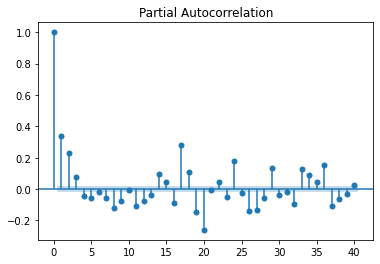

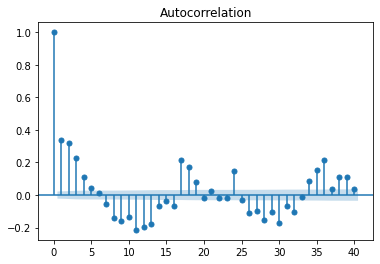

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plot_pacf(train['crimes'])
plot_acf(train['crimes'])
plt.show()

Here, I looked at the partial autocorrelation and autocorelation of the number of crimes on a week-to-week basis. The autocorrelation plot shows a possible seasonality in the data. Due to the time limit, I will not do a deeper analysis and will take the basic components of a time series: 1 week lag, the difference from previos week, and rolling average of the last 4 weeks (since we want to predict the first 4 weeks of March 2015)


In [42]:
#Splitting the dataset for train and test 
split_point = 80
test = train[train['week'] >= split_point].copy()
train = train[train['week'] < split_point].copy()

In [43]:
train

,area,week,crimes
0,1,0,68
1,2,0,62
2,3,0,62
3,4,0,29
4,5,0,19
...,...,...,...
6155,73,79,62
6156,74,79,13
6157,75,79,46
6158,76,79,29


In [44]:
# Create next_week variable (my targer variable)
train['next_week'] = train.groupby('area')['crimes'].shift(-1)
train.dropna(inplace=True)

In [45]:
# Create week_lag
train['lag_week'] = train.groupby('area')['crimes'].shift(1)

In [46]:
# Create week_diff
train['diff_week'] = train.groupby('area')['crimes'].diff()

In [47]:
# Create rolling avg of the last 4 weeks
train['rolling_4'] = train.groupby('area')['crimes'].rolling(4).mean().reset_index(level=0, drop=True)

Here, I will just drop all the null values. In a real-world project, I would explore the different metrics I get with different types of imputation methods.

In [48]:
train.dropna(inplace=True)

In [49]:
train = train.astype({'crimes':'float',
    'next_week':'float',
    'lag_week':'float',
    'diff_week':'float',
    'rolling_4':'float'})

In [50]:
y_pred = train['crimes']
y_true = train['next_week']

In [51]:
from sklearn.metrics import r2_score, mean_squared_error
print(mean_squared_error(y_true, y_pred))
print(r2_score(y_true,y_pred))

203.47744360902254
0.9501531653348975


In [52]:
# Create function to apply the same procedure to the test data

def features(df):

    # Create next_week variable (my targer variable)
    df['next_week'] = df.groupby('area')['crimes'].shift(-1)
    df.dropna(inplace=True)

    # Create week_lag
    df['lag_week'] = df.groupby('area')['crimes'].shift(1)

    # Create week_diff
    df['diff_week'] = df.groupby('area')['crimes'].diff()

    # Create rolling avg of the last 4 weeks
    df['rolling_4'] = df.groupby('area')['crimes'].rolling(4).mean().reset_index(level=0, drop=True)

    df.dropna(inplace=True)
    
    df = df.astype({'crimes':'float',
    'next_week':'float',
    'lag_week':'float',
    'diff_week':'float',
    'rolling_4':'float'})
    
    return df

In [53]:
# Function to prepare new data from the beginning
def data_prep(df):
    column_list = list(df.groupby('Date').count().index)
    index_list = [x for x in range(1,78,1)]
    train = pd.DataFrame(index=index_list, columns = column_list)
    for i in index_list:    
        train.loc[i,:] = df[df['Community.Area']==i]['Case.Number'].to_list()
    
    train.reset_index(inplace=True)
    train.rename(columns={'index':'area'},inplace=True)
    train = train.melt(id_vars='area', var_name = 'week', value_name='crimes')
    foo = {}
    for i,week in enumerate(train.week.unique()):
        foo[week] = i
    train.replace({'week':foo}, inplace=True)

    return features(train)



In [54]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(train.drop(columns='next_week'), train.next_week)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [55]:
test = features(test)

In [56]:
pred = clf.predict(test.drop(columns='next_week'))

In [57]:
print(mean_squared_error(test.next_week, pred))
print(r2_score(test.next_week, pred))

208.57020954545456
0.9403902965160834


Here we can see a very small improvemnt in the metrics when comparing the baseline (this week predicts next week) vs the RandomForestRegressor. In a real-world setting, I would do hyperparameter tuning. I would also spend more time in the feature engineering. I would also try at least two other models, such as LinearRegression, OLS, Lasso, etc. I chose RandomForestRegressor because it tends to be one of the most robust models.

At this point, once the model/models are tuned, I would proceed to train it with all the training data.

In [58]:
df = data[data.Date.between('2013','12/28/2014')].groupby([pd.Grouper(key='Date', freq='W-SUN'), 'Community.Area'])['Case.Number'].count().reset_index()
df = data_prep(df)
clf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(df.drop(columns='next_week'), df.next_week)


RandomForestRegressor(n_jobs=-1, random_state=42)

Now, let's create the predictions for the first 4 weeks of March 2015, and then we will rank the results.


Since we the most weeks the use in our feature engineering are 4 weeks for the rolling average, I will use the previous 4 weeks to predict the target week:

In [59]:
def march_pred(date):

    df = data_prep(data[data.Date.between('2015',date)].groupby([pd.Grouper(key='Date', freq='W-SUN'), 'Community.Area'])['Case.Number'].count().reset_index()).drop(columns='next_week')
    df = pd.DataFrame(clf.predict(df[df.week == 6]), index = range(1,78,1))
    df.index.name = 'Community'
    df = df.sort_values(0, ascending=False).reset_index()
    df['PREDICTED.RANK'] = [x for x in range(1,78,1)]
    df['Week'] = pd.to_datetime(date) + pd.Timedelta(days=1)
    return df[['Community', 'Week', 'PREDICTED.RANK']].sort_values('Community')

In [60]:
march1 = march_pred('02/28/2015')
march2 = march_pred('03/7/2015')
march3 = march_pred('03/14/2015')
march4 = march_pred('03/21/2015')


In [61]:
march1.append(march2).append(march3).append(march4).to_csv('March_2015_Rankings_[PACHECO]_[RONALD].csv')